# Project Report

Group Number: 4

Group Members: Jezarah Ebel, Amar Gill, Yoson Hsu, Hao Jiang, Kaiji Lo

Data Set: Data Science Jobs Salaries

In [1]:
#required libraries
library(cowplot)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(repr)
library(infer)
library(broom)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()



## 1 Introduction

During COVID-19 the work from home (WFH) model was adopted by many companies to keep employees safe from the virus; 32% of Canadian employees in 2021 worked from home compared to 4% in 2016 (Mehdi). In general, it has been proven that employee’s productivity is not affected if their personal work environment at home provides good privacy, noise, and allows developers to work with less fragmentation or interruptions (Bao). 

Should an employee expect their salary to change based on where they work (from home or at the office)?

To explore this question, the dataset that we will be using, Data Science Jobs Salaries Dataset (Shahane), includes salary data for employees in the data science industry such as the work year, experience level, employment type, the job title, salary, employee residence, the ratio of remote work, location of company, and size of company. The data set is taken from workers during the years 2020 and 2021. The data source is from ai-jobs.net. To answer our questions, we will be looking at the salary in USD and the ratio of remote work (0% remote vs. 100% remote). 

To test the hypothesis that there is a statistically significant difference in mean salary between workers who work remotely vs those who work in office, we will apply both bootstrapping as well as mathematical approximation methods to test our hypotheses. 

## 2 Preliminary Results

### Cleaning and Wrangling of Data

In [2]:
download.file("https://raw.githubusercontent.com/Wills-Hao/201-Project/main/Data_Science_Jobs_Salaries.csv", destfile = "Data_Science_Jobs_Salaries.csv")

DsSalary <- read_csv("Data_Science_Jobs_Salaries.csv")
head(DsSalary)

Rows: 245 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (4): work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
2021,EN,FT,Data Science Consultant,54000,EUR,64369,DE,50,DE,L
2020,SE,FT,Data Scientist,60000,EUR,68428,GR,100,US,L
2021,EX,FT,Head of Data Science,85000,USD,85000,RU,0,RU,M
2021,EX,FT,Head of Data,230000,USD,230000,RU,50,RU,L
2021,EN,FT,Machine Learning Engineer,125000,USD,125000,US,100,US,S
2021,SE,FT,Data Analytics Manager,120000,USD,120000,US,100,US,M


As the introduction mentioned, we are interested in the data-related workers working remotely or not (the remote ratio of 0 and 100). Since the remote ratio and the salary(USD) are the only columns we are interested in, we just select them for the cleaned data frame.

In [3]:
clean_DsSalary <- DsSalary %>%
                  filter(!is.na(salary_in_usd&remote_ratio),
                         remote_ratio %in% c(0, 100)) %>%
                  mutate(remote_ratio = as_factor(remote_ratio)) %>%
                  select(remote_ratio, salary_in_usd)
head(clean_DsSalary)

options("scipen"=100)

remote_ratio,salary_in_usd
<fct>,<dbl>
100,68428
0,85000
100,125000
100,120000
0,450000
100,144000


### Estimation of the Parameter

At first, we separately calculated the mean salaries of data-related workers who worked remotely (remote ratio > 80%) and the mean salaries of data-related workers who didn't work remotely (remote ratio < 20%). From the result below, we can see that the mean salary of remote workers has higher salaries. Then we find the difference between the two means is around 30145.229 USD, which can be seen as an estimation of the parameter.

In [4]:
remote_df <- clean_DsSalary %>%
                  filter(remote_ratio == 100) %>%
                  select(salary_in_usd)
 
remote_mean <- remote_df %>%
                summarise(mean_remote = mean(salary_in_usd))
remote_mean

no_remote_df <- clean_DsSalary %>%
                filter(remote_ratio == 0) %>%
                select(salary_in_usd)

no_remote_mean <- no_remote_df %>%
                 summarise(mean_office = mean(salary_in_usd))
no_remote_mean

mean_remote
<dbl>
115107.7


mean_office
<dbl>
84962.45


In [5]:
estimation_diff_mean <- pull(remote_mean) - pull(no_remote_mean)
estimation_diff_mean


[1] 30145.23

### Visualizing the Data

Firstly, we will plot the raw data distribution of two data frames(the remote working one and the no remote working one) with the vertical lines of their mean value. By comparing them, we can see that the mean salary of remote workers has a higher value of salary.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


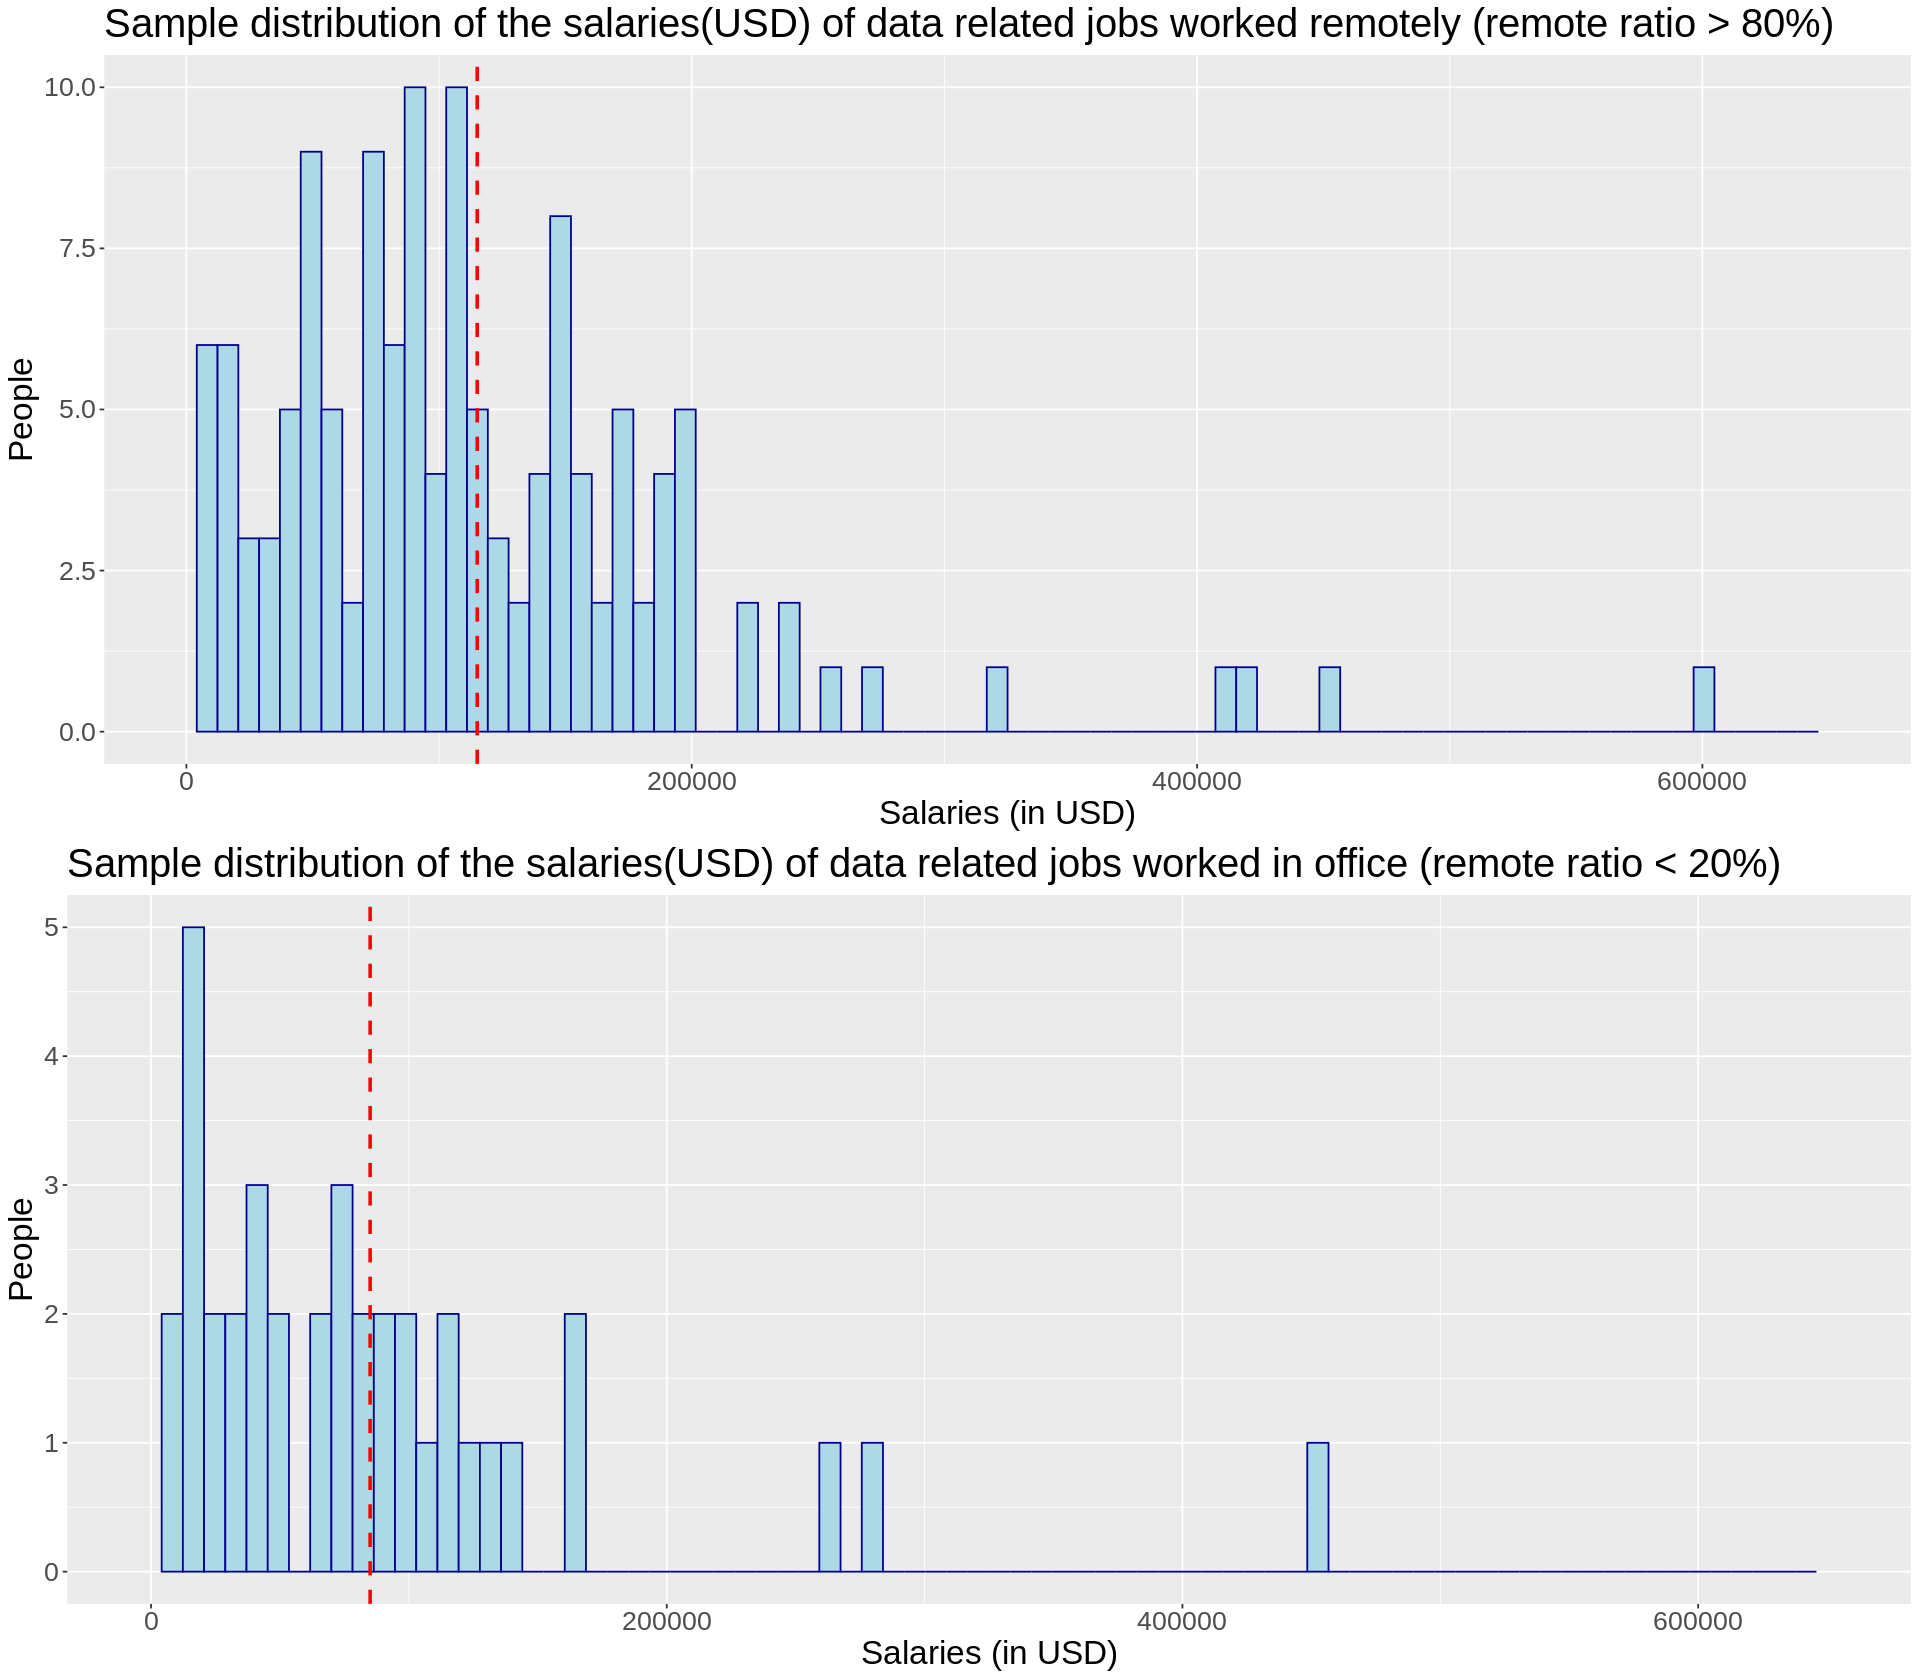

In [6]:
remote_distribution <- remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(bins=80, color="darkblue", fill="lightblue") +
                          geom_vline(aes(xintercept = pull(remote_mean)), color="red", linetype="dashed", size = 1)+
                          ggtitle("Sample distribution of the salaries(USD) of data related jobs worked remotely (remote ratio > 80%)")+
                          labs(x="Salaries (in USD)",
                               y="People")+
                          theme(text = element_text(size=20)) 

no_remote_distribution <- no_remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(bins=80, color="darkblue", fill="lightblue") +
                          geom_vline(aes(xintercept = pull(no_remote_mean)), color="red", linetype="dashed", size = 1)+
                          ggtitle("Sample distribution of the salaries(USD) of data related jobs worked in office (remote ratio < 20%)")+
                          labs(x="Salaries (in USD)",
                               y="People")+
                          theme(text = element_text(size=20))

options(repr.plot.width = 16, repr.plot.height = 14)

mean_plot_row <- plot_grid(remote_distribution+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           no_remote_distribution+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           nrow = 2)
mean_plot_row

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


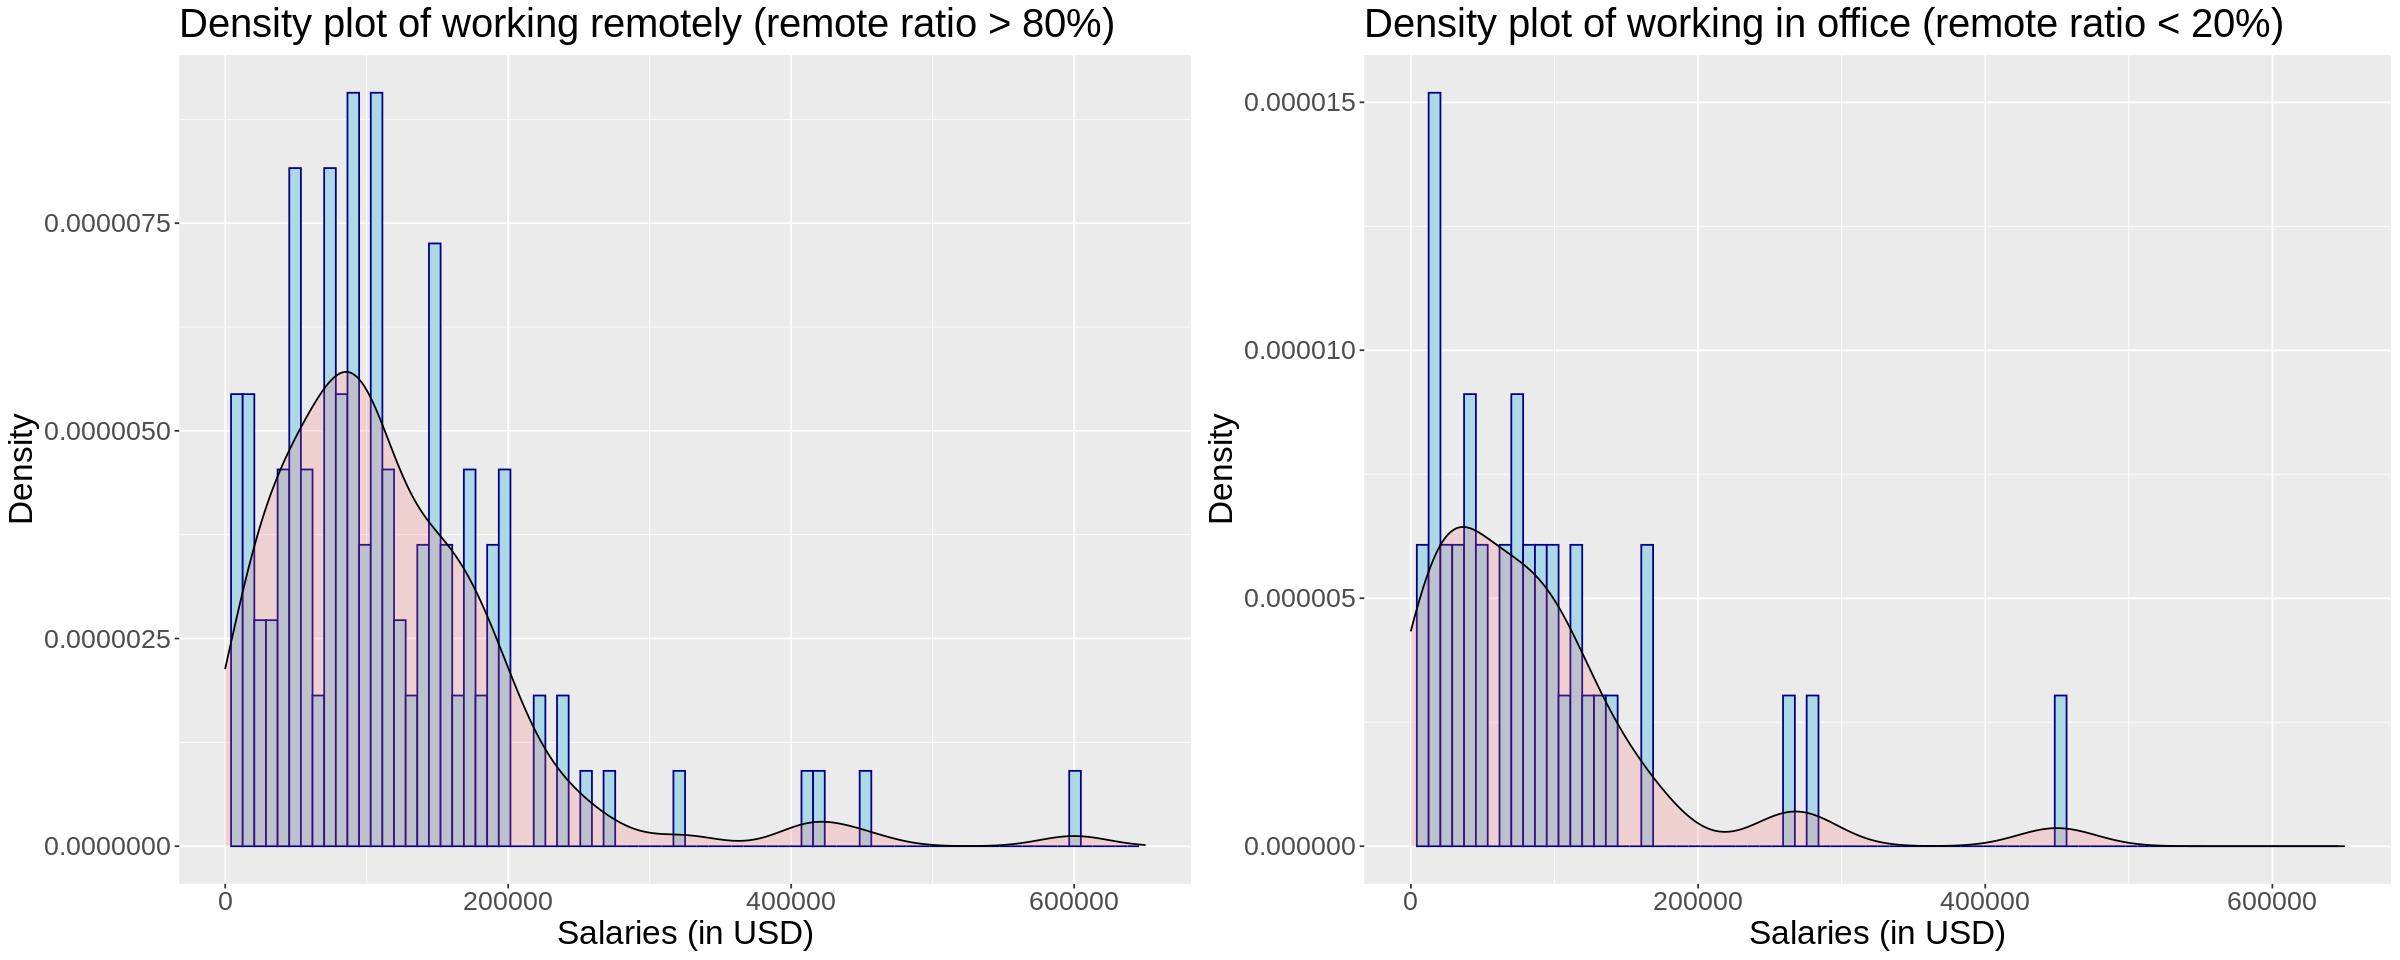

In [7]:
remote_density <- remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(aes(y=..density..), bins=80, color="darkblue", fill="lightblue") +
                          geom_density(alpha=.2, fill="#FF6666")+
                          labs(x = "Salaries (in USD)",
                               y = "Density")+
                          ggtitle("Density plot of working remotely (remote ratio > 80%)")+
                          theme(text = element_text(size=20))
no_remote_density <- no_remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(aes(y=..density..), bins=80, color="darkblue", fill="lightblue") +
                          geom_density(alpha=.2, fill="#FF6666")+
                          labs(x = "Salaries (in USD)",
                               y = "Density")+
                          ggtitle("Density plot of working in office (remote ratio < 20%)")+
                          theme(text = element_text(size=20))

options(repr.plot.width = 20, repr.plot.height = 8)

density_plot <- plot_grid(remote_density+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           no_remote_density+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           ncol = 2)
density_plot

From the density plots, we can see both of them are skewed to the right.

## 3 Hypothesis Testing

For this section, we will use hypothesis testing to determine whether there is enough statistical evidence in favor of the statement that the mean salary for data scientists who work remotely is different from the mean salary for data scientists who does not work remotely. For this project, we set the 0.95 `confidence level`, which means a 0.05 significance level.

The null hypothesis ($H_0$): There is `no difference` between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely.

The alternative hypothesis ($H_A$): There is `a difference` between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely.


$\mu_1$: The population mean of salary for data scientists who `work remotely`

$\mu_2$: The population mean of salary for data scientists who does not `work remotely`

$H_0: \mu_1 - \mu_2 = 0$

$H_A: \mu_1 - \mu_2 \neq 0$

### Bootstrapping method

First, we will review the `observed test statistic` (the difference between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely from the dataset) calculated in the preliminary results section. Then, we will use the `infer` package to obtain the bootstrapped sampling distribution to estimate the sampling distribution, so that we can use it to find out the `p-value` (the probability of getting a value more "extreme" than the observed test statistic). Also, we will construct a `confidence interval` based of the confidence level on the bootstrap distribution. Based on the p-value and the confidence interval, we can reject or not reject the null hypothesis $H_0$. 

In [8]:
# Review of the obeserved test statistic
cat("The value of the observed test statistic is", estimation_diff_mean)

The value of the observed test statistic is 30145.23

#### Find the null distribution and the p-value 

In [9]:
# Using the infer package, to obtain the bootstrapped sampling distribution of test statistic 
# by 1000 replications
set.seed(33)

sampling_dist_mean_salary <-  
   clean_DsSalary %>%
   specify(formula = salary_in_usd ~ remote_ratio) %>% 
   hypothesize(null = "independence") %>% 
   generate(reps = 1000, type = "permute") %>% 
   calculate(stat="diff in means", order = c(100, 0))

head(sampling_dist_mean_salary)

replicate,stat
<int>,<dbl>
1,-11512.221
2,1115.439
3,4753.435
4,-8460.274
5,-10197.710
6,9653.548


Since the alternative hypothesis is $\mu_1 - \mu_2 \neq 0$, we will find the p-value by the two sided direction (region shaded in red below). 

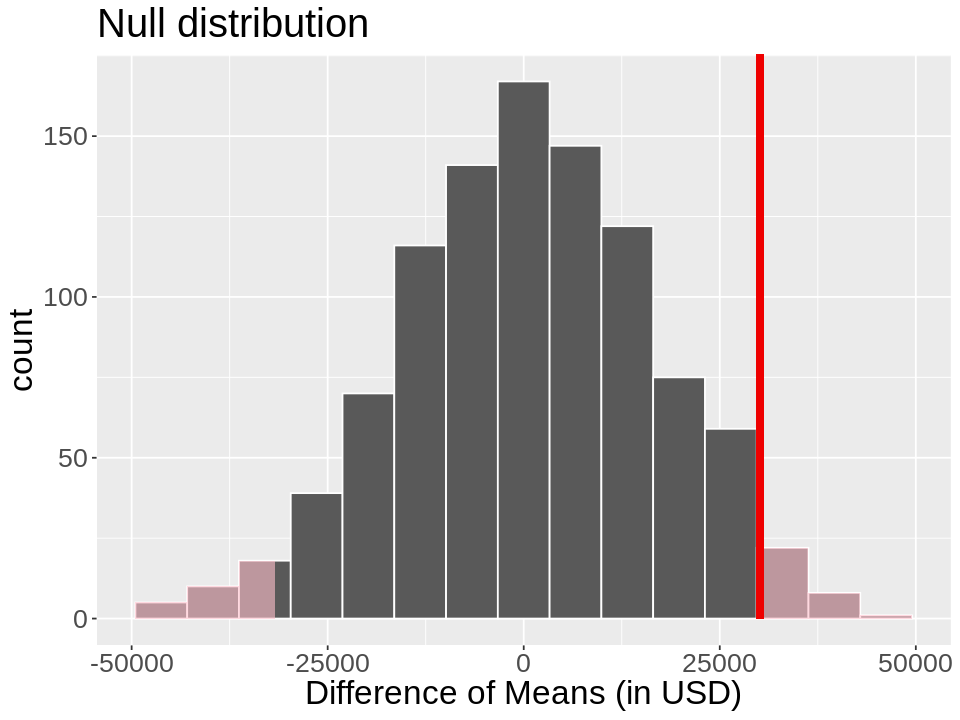

In [10]:
# Plot the result of the hypothesis test with the vertical line of the test statistic's position

options(repr.plot.width = 8, repr.plot.height = 6)
result_plot_students <- 
   sampling_dist_mean_salary %>%
   visualize() + 
   shade_p_value(obs_stat = estimation_diff_mean, direction = "two-sided") +
   ggtitle("Null distribution")+
   labs(x = "Difference of Means (in USD)")+
   theme(text = element_text(size = 20))

result_plot_students

In [11]:
# Obtaining the p-value

p_value_mean_salary <- 
    sampling_dist_mean_salary %>% 
    get_p_value(obs_stat = estimation_diff_mean, direction = "two-sided") %>%
    pull()

cat("The P-value is", p_value_mean_salary)

The P-value is 0.054

#### Find the bootstrap distribution and the 95% confidence interval

In [12]:
# Using the infer package, to obtain the bootstrap distribution of test statistic by 1000 replications
set.seed(333)

bootstrap_dist_diff_in_mean <-  
   clean_DsSalary %>%
   specify(formula = salary_in_usd ~ remote_ratio) %>% 
   generate(reps = 1000, type = "bootstrap") %>% 
   calculate(stat="diff in means", order = c(100, 0))

# Obtain the 95% confidence interval
diff_in_means_ci <- bootstrap_dist_diff_in_mean %>%
                    get_confidence_interval(level = 0.95, type = "percentile") 

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-4753.858,59264.13


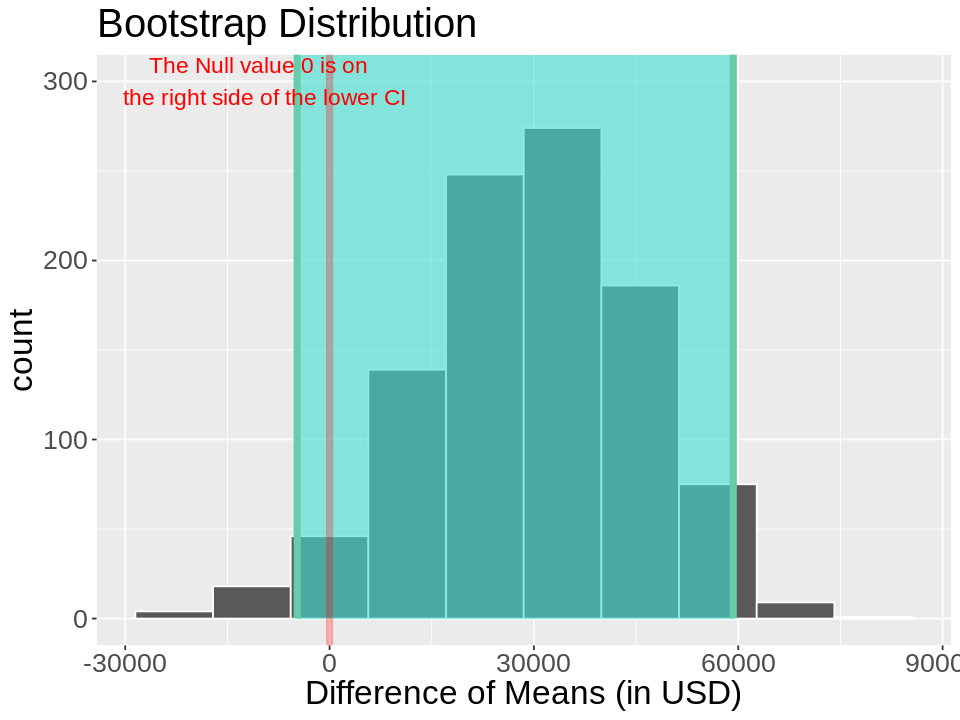

In [13]:
# The Plot of the confidence interval in bootstrap distribution with a vertical line 
# of the value of H_0 (null value)

options(repr.plot.width = 8, repr.plot.height = 6)
diff_in_means_ci_plot <- bootstrap_dist_diff_in_mean %>%
                        visualize(bins = 10) +
                        shade_confidence_interval(endpoints = diff_in_means_ci) +
                        xlab("Difference of Means (in USD)")+
                        ggtitle("Bootstrap Distribution") +
                    geom_vline(xintercept = 0, color = "red", alpha=.3, lwd=2)+
                    annotate("text", x = -10000, 
                             y =300, label = "The Null value 0 is on \n the right side of the lower CI", 
                             color="red", size=4.8)+
                    theme(text = element_text(size = 20))
    
diff_in_means_ci_plot

#### Result of the bootstrap method:

Two methods are used to determine whether reject the null hypothesis (no difference), one is by comparing the p-value and the significance level, and another is by determining whether the confidence interval embraced the value of the null hypothesis which is 0 (null value). 

First of all, the `p-value` of 0.054 which is larger than the `significant level` of 0.05 is not statistically significant. It does not show strong evidence against the null hypothesis because the probability of the null hypothesis being correct is larger than 5%. Therefore, we should not reject the null hypothesis and don't accept the alternative hypothesis.

Secondly, the `null value` of the difference between the two groups' mean salary is 0, which is contained in the `confidence interval` (-4753.858, 59264.13). It indicates that the null value 0 is a reasonable value for the true difference in mean salaries between the two groups. Thus, we fail to reject the null hypothesis.

In summary, we can't say there is a difference between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely.

### Central Limit Theorem 

There are alternatives to bootstrapping when it comes to studying sampling distributions, specifically methods that rely on mathematical modeling and approximations. One method relies on the `central limit theorem` which tells us that when we increase our sample size and take a sampling distribution we reduce the variability of sample means. This reduction in variability improves the center of our sampling distribution and thus the quality of the estimate.

Central Limit Theorem is also useful in our scenario, as it states if our sample size is large enough our sampling distribution can be approximated with a normal distribution regardless of the population distribution. This is a useful approximation for us because we don't know the distribution of our population and we have no feasible way of gathering that information. By taking the sampling distribution and applying the central limit theorem we can theoretically make a better estimate for our parameter of interest (difference in means). Note we are additionally assuming that our sample is unbiased.

#### Samples

Since we are interested in the difference between two related populations, our samples will need to be taken from both groups. As shown above we do have a larger number of observations from fully remote workers (134) than from in office workers (40).

In [14]:
remote_ratio_0 <- clean_DsSalary %>%
    mutate(remote_ratio_factor = as.factor(remote_ratio)) %>%
    filter(remote_ratio_factor == "0") %>%
    select(remote_ratio, salary_in_usd)

remote_ratio_100 <- clean_DsSalary %>%
    mutate(remote_ratio_factor = as.factor(remote_ratio)) %>%
    filter(remote_ratio_factor == "100") %>%
    select(remote_ratio, salary_in_usd)

In [15]:
sample_10_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 10, reps = 3000, replace = FALSE)

sample_10_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 10, reps = 3000, replace = FALSE)

sample_10 <- merge(sample_10_0, sample_10_100,
                    all = TRUE)

sample_20_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 20, reps = 3000, replace = FALSE)

sample_20_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 20, reps = 3000, replace = FALSE)

sample_20 <- merge(sample_20_0, sample_20_100,
                    all = TRUE)

sample_30_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 30, reps = 3000, replace = FALSE)

sample_30_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 30, reps = 3000, replace = FALSE)

sample_30 <- merge(sample_30_0, sample_30_100,
                    all = TRUE)

sample_40_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 40, reps = 3000, replace = FALSE)

sample_40_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 40, reps = 3000, replace = FALSE)

sample_40 <- merge(sample_40_0, sample_40_100,
                    all = TRUE)

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


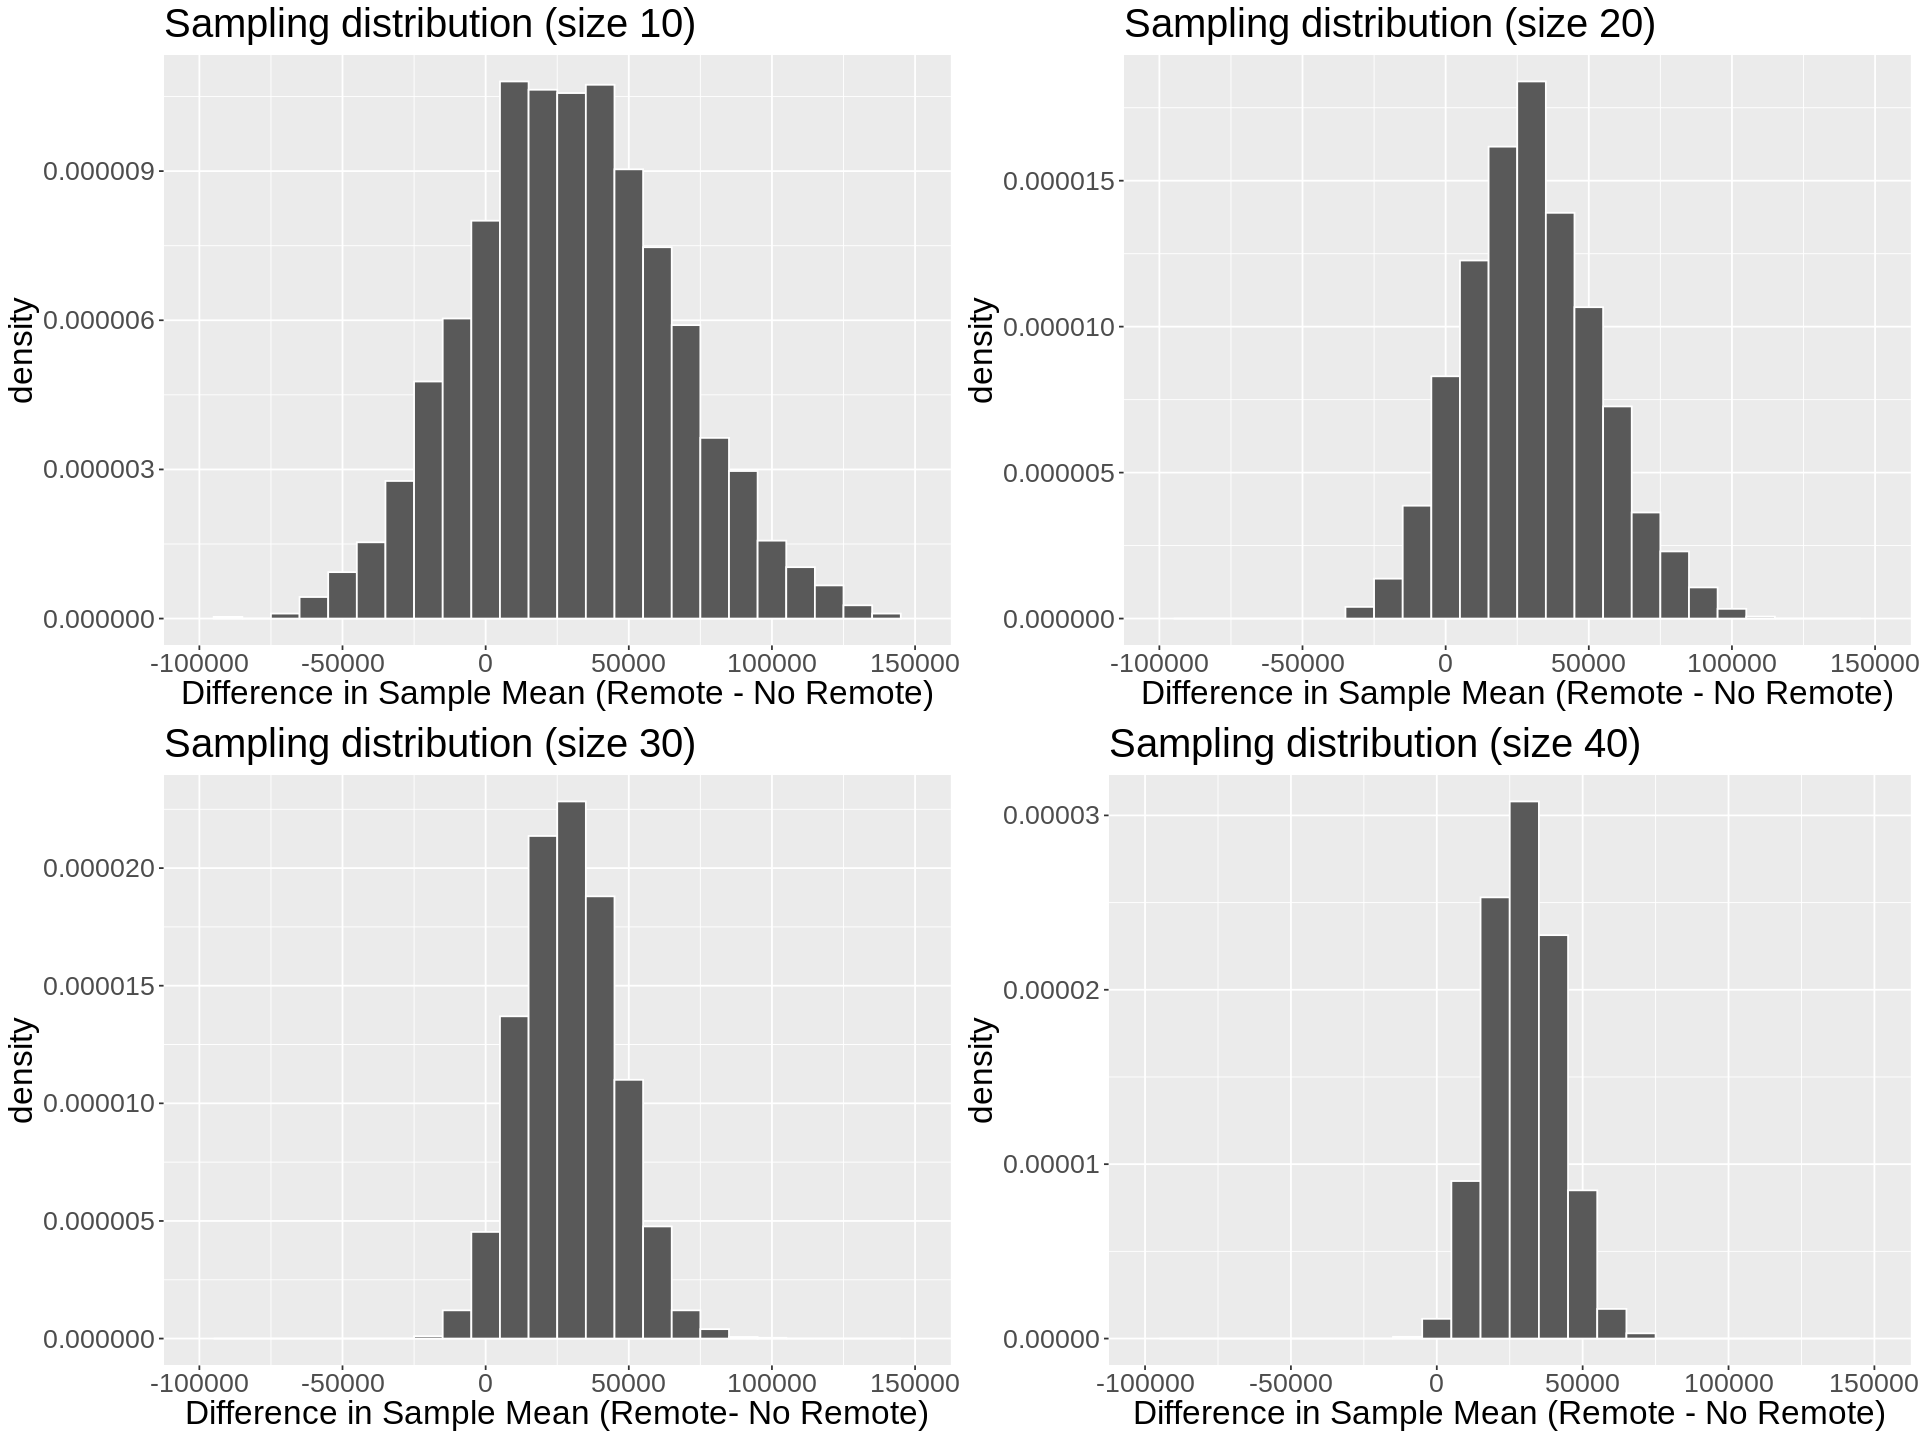

In [16]:
options(repr.plot.width = 16, repr.plot.height = 12)

sampling_dist_10 <- sample_10 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote - No Remote)") +
    ggtitle("Sampling distribution (size 10)")  

sampling_dist_20 <- sample_20 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote - No Remote)") +
    ggtitle("Sampling distribution (size 20)")  

sampling_dist_30 <- sample_30 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote- No Remote)") +
    ggtitle("Sampling distribution (size 30)")  

sampling_dist_40 <- sample_40 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote - No Remote)") +
    ggtitle("Sampling distribution (size 40)")  

grid.arrange(sampling_dist_10, sampling_dist_20, sampling_dist_30, sampling_dist_40, ncol = 2, nrow = 2)

As seen above, we see that the central limit theorem seems to apply to our sample, we see that the center of the distributions is approximately the same and as we increase the sample size the normal distribution narrows (less spread). The normal distribution shape is seen in this case in all the sample sizes we tried.

#### Confidence Interval by Central Limit Theory

We can try to approximate the sampling distribution of $\bar{X}_1-\bar{X}_2$ by
$$
\bar{X}_1-\bar{X}_2\sim N\left(\mu_1 - \mu_2, \sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}\right)
$$

and find the Confidence Interval by 
$$
CI\left(\mu_1 - \mu_2\right) = \left(\bar{X}_1-\bar{X}_2\right) \pm z^*\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}
$$
where $z^*$ is the quantile of a standard Normal.

We are interested in a `95% Confidence Interval`.

In [17]:
wfh <- remote_ratio_100 %>%
    select(salary_in_usd)

office <- remote_ratio_0 %>%
    select(salary_in_usd)

DsSalary_diff_means_ci <- 
     tibble(
         lower_ci = mean(wfh$salary_in_usd) - mean(office$salary_in_usd) + qnorm(0.025) * sqrt(var(wfh$salary_in_usd)/nrow(wfh) + var(office$salary_in_usd)/nrow(office)),
         upper_ci = mean(wfh$salary_in_usd) - mean(office$salary_in_usd) + qnorm(0.975) * sqrt(var(wfh$salary_in_usd)/nrow(wfh) + var(office$salary_in_usd)/nrow(office))
     )

DsSalary_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-804.1641,61094.62


#### Result of the Central Limit Theory Method:

The `95% Confidence Interval` given by the above approximation is (-804.16, 61,094.62). Our null value is 0, which is does fall within the interval, therefore based on this approximation we would not reject the null hypothesis at a 5% significant level. 

### Student's t-test (t-distribution)

Additionally, we will try to apply a `Student's t-test (t-distribution)` which may result in a better approximation. Similar to the normal distribution in the shape however is different in that the center is always 0 and the spread is controlled by a variable called the degree of freedom. 

To answer our question $H_0: \mu_1 - \mu_2 = 0$ and $H_a: \mu_1 - \mu_2 \neq 0$, let's use the `t test function`to calculate our `p-value`. 

In [18]:
t_test <- tidy(
    t.test(wfh,
           office,
           alternative = "two.sided", )
    ) 
t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
30145.23,115107.7,84962.45,1.909038,0.06060505,66.02075,-1381.929,61672.39,Welch Two Sample t-test,two.sided


#### Result of the Student's t-test: 

We obtained a `p-value` of 0.06 from our t-test, therefore at a `0.05 significance level`, we do not reject the null hypothesis since the p-value is larger than our significance level. 

### Bootstrap Method vs Central Limit Theorem

Bootstrapping is an alternative to asymptotic approximation for carrying out inference. The idea is to mimic the variation from drawing different samples from a population by the variation from redrawing samples from a sample. The asymptotic analysis uses a large population and the number of samples is much larger. In this problem, bootstrapping is better than the central limit theorem. Because the volume of the sample and the population are small. The advantage of the bootstrap method is that it is a straightforward way to derive estimates of standard errors and confidence intervals, and it is convenient because it avoids the expense of repeating the experiment to obtain sampled data for other groups.

The 95% Confidence Interval given by the above approximation is (-804.16, 61,094.62). Our null value is 0, which does fall within the interval, therefore based on this approximation we would not reject the null hypothesis at a 5% significant level. The null value of the difference between the two groups' mean salary is 0, which is not contained in the confidence interval (-4753.858, 59264.13). It indicates that the null value 0 is a reasonable value for the true difference in mean salaries between the two groups. Thus, we do not reject the null hypothesis. I think the bootstrapping approach is better, with a 95% confidence interval, the results obtained by this method are more realistic.

##  4 Discussion

In this project, we are expecting to find the salary difference between people who work within the office and people who work remotely, although this will vary with many other factors which we examine in this project. What we found is that since we did not reject our null hypothesis, this suggests that the difference in salary between those who work within the office and those who work remotely is not significantly different than our null hypothesis of 0, meaning that employees are likely to earn the same amount as their peers regardless of whether they choose to work at home or in the work environment.

Due to COVID, a large majority of companies that had to ability to be performed online allowed their employees to work remotely, and this is due in part to reducing the spread of the virus. After the spread of the virus decreased over time, companies were asking employees to return to the workplace, but after experiencing the feeling of working from home, some employees did not return and this made some companies change their policies to allow remote work. It is possible that some employees, even though they preferred working at home, would be inclined to return to work due to exterior reasoning. There are a plethora of future studies that can stem from this current study. Some could lead to include finding what other factors will affect a greater salary, such as company size and location. Other analyses could even build off of our project by constructing a model of the salary difference for people who work hybrid vs people who work in the office. This would be a more realistic approach to the data as companies are more likely Of course, this cannot be done with our model as there we only filter the people with a 100% remote ratio and people who work with a 0% remote ratio. Another interesting future study could analyze the impact that experience has on salary, with respect to remote and non-remote jobs.


## 5 Reference

Bao, L., Li, T., Xia, X. et al. How does working from home affect developer productivity? — A case study of Baidu during the COVID-19 pandemic. Sci. China Inf. Sci. (2022). https://doi.org/10.1007/s11432-020-3278-4

Mehdi, T. Morissette, R. Working from home: Productivity and preference. Statistics Canada. (2021).
https://publications.gc.ca/collections/collection_2021/statcan/45-28/CS45-28-1-2021-12-eng.pdf

Shahane, S. Data Science Jobs Salaries Dataset. Kaggle. (2022). 
https://www.kaggle.com/datasets/saurabhshahane/data-science-jobs-salaries
